# Issue Primary Medical Qualifications

The Edinburgh Medical School is trusted to establish secure DIDComm connections with each of the medics studing at the school, likely created at the start of their education.

Once the medic completes their education and passes their exams they are issued a digital Primary Medical Qualification across this established connection.

The school just needs to keep track of connection_identifiers, the students they identify and when they successfully complete their education. Likely they already do this in some fashion so this would require minor changes to their systems.

Students would need to install and manage an SSI application which they can use to establish these connections and later receive, store and present the Primary Medical Qualification.


![Medic Education](./medic-education-sd.png)

# System Setup

This would be an application installed and running on the medical schools secure servers.

![Secure Server](https://static.thenounproject.com/png/65152-200.png)

### Imports

In [1]:
from aries_cloudcontroller import AriesAgentController
import os
from termcolor import colored

### Initialise the Agent Controller

In [2]:
api_key = os.getenv("ACAPY_ADMIN_API_KEY")
admin_url = os.getenv("ADMIN_URL")

print(f"Initialising a controller with admin api at {admin_url} and an api key of {api_key}")
agent_controller = AriesAgentController(admin_url,api_key)

Initialising a controller with admin api at http://edinburgh-medical-school-agent:3021 and an api key of adminApiKey


### Start a Webhook Server

In [3]:
webhook_port = int(os.getenv("WEBHOOK_PORT"))
webhook_host = "0.0.0.0"

await agent_controller.init_webhook_server(webhook_host, webhook_port)

print(f"Listening for webhooks from agent at http://{webhook_host}:{webhook_port}")

Listening for webhooks from agent at http://0.0.0.0:3010


## Register Agent Event Listeners

You can see some examples within the webhook_listeners recipe. Copy any relevant cells across and fill in additional logic as needed.

In [4]:
listeners = []

In [5]:
## YOUR LISTENERS HERE
# Receive connection messages
def connections_handler(payload):
    state = payload['state']
    connection_id = payload["connection_id"]
    their_role = payload["their_role"]
    routing_state = payload["routing_state"]
    
    print("----------------------------------------------------------")
    print("Connection Webhook Event Received")
    print("Connection ID : ", connection_id)
    print("State : ", state)
    print("Routing State : ", routing_state)
    print("Their Role : ", their_role)
    print("----------------------------------------------------------")
    if state == "active":
        # Your business logic
        print(colored("Connection ID: {0} is now active.".format(connection_id), "green", attrs=["bold"]))

connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

listeners.append(connection_listener)

In [6]:
def issuer_handler(payload):
    connection_id = payload['connection_id']
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    print("\n---------------------------------------------------\n")
    print("Handle Issue Credential Webhook")
    print(f"Connection ID : {connection_id}")
    print(f"Credential exchange ID : {exchange_id}")
    print("Agent Protocol Role : ", role)
    print("Protocol State : ", state )
    print("\n---------------------------------------------------\n")
    
    
    if state == "offer_sent":
        proposal = payload["credential_proposal_dict"]
        attributes = proposal['credential_proposal']['attributes']

        print(f"Offering credential with attributes  : {attributes}")
        ## YOUR LOGIC HERE
    elif state == "request_received":
        print("Request for credential received")
        ## YOUR LOGIC HERE
    elif state == "credential_sent":
        print("Credential Sent")
        ## YOUR LOGIC HERE
    
issuer_listener = {
    "topic": "issue_credential",
    "handler": issuer_handler
}

listeners.append(issuer_listener)

In [7]:
agent_controller.register_listeners(listeners)

## Store Issuing Schema and Cred Def Identifiers

If you intend for this agent to issue credentials you should first initialise your agent as an issuer and author the relevant identifiers to the public ledger. The issuer_initialisation recipe notebook can be duplicated and used as a starting point.

Once schema and cred def identifiers are created copy across and store in variables as illustrated in the cell below. Be sure to use unique names for each variable.

In [8]:
pmq_schema_id = '3jnXQcj9VLFjcUbtDVZZzV:2:Primary Medical Qualification:0.0.2'
pmq_cred_def_id ='3jnXQcj9VLFjcUbtDVZZzV:3:CL:14:default'



%store pmq_schema_id
%store pmq_cred_def_id

Stored 'pmq_schema_id' (str)
Stored 'pmq_cred_def_id' (str)


# Connect with Medic

Connection could be established at any time, but ideally it would be done as part of the medic joining or even applying to join the medical school. Already there exists strong authentication processes by which university applications and their applicants are vetted.

Furthermore, creating a secure DIDComm connection with medical students provides interesting opportunities to make use of this communications channel throughout the medics education.

In our model we make the assumption that medical schools only make connections with medical students and only issue PMQ's to those who successfully complete their education. 

![](https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/UCAS_logo.svg/1200px-UCAS_logo.svg.png)

## Create a Connection Invite for the Medic's Agent

This connection, once established, will act as the persistent digital identitifer by which the medical school can identify, authentication and interact with a digital agent acting on behalf of the medical student. This could have many uses, including system login, secure communications, exam attendance and results and placement assignments.

In these notebooks we will focus on the basic set of credentials that a healthcare professional has to manage throughout their career already.

In [9]:
# Alias for invited connection
alias = "Medic"
auto_accept = "true"
# Use public DID?
public = "false"
# Should this invitation be usable by multiple invitees?
multi_use = "false"

invitation_response = await agent_controller.connections.create_invitation(alias, auto_accept, public, multi_use)
# Is equivalent to above. Arguments are optionally
# invitation_response = await agent_controller.connections.create_invitation()



# You will use this identifier to issue a credential across this connection
connection_id = invitation_response["connection_id"]

----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  f363c9a0-c02d-4296-8c9d-08e2d808652e
State :  invitation
Routing State :  none
Their Role :  invitee
----------------------------------------------------------


## Share Invitation Object with Medic

This could take place as part of being accepted onto a medical degree, perhaps integrated into UCAS. Or alternatively the connection could be established once a medic arrives at Edinburgh Medical School as part of their onboarding process.

In [10]:
invitation = invitation_response["invitation"]
## Copy this output
print(invitation)

{'@type': 'did:sov:BzCbsNYhMrjHiqZDTUASHg;spec/connections/1.0/invitation', '@id': '7f5c7343-8a24-4aca-b147-52942c3c0456', 'serviceEndpoint': 'http://ebf7-82-33-73-116.ngrok.io', 'label': 'Edinburgh Medical School', 'recipientKeys': ['7Vq6r3woRoGe8SsQtPggrB4SMdeSuxbNMPY3yspHFKg4']}
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  f363c9a0-c02d-4296-8c9d-08e2d808652e
State :  request
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  f363c9a0-c02d-4296-8c9d-08e2d808652e
State :  response
Routing State :  none
Their Role :  invitee
----------------------------------------------------------
----------------------------------------------------------
Connection Webhook Event Received
Connection ID :  f363c9a0-c02d-4296-8c9d-08e2d808652e
State :  active
Routing State :  no

## Optional: Display Invite as QR Code

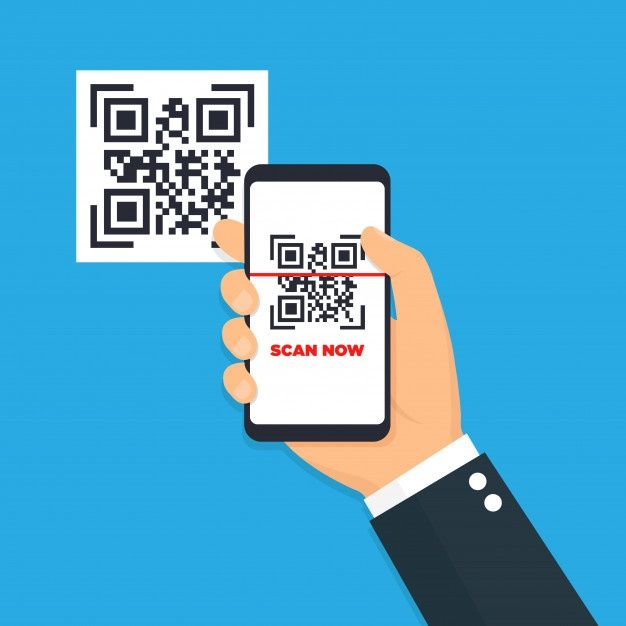

It is likely a Medic will manage their connections and credentials through a mobile application. For simplicity we are using a notebook to represent the medic.

In [ ]:
import qrcode
# Link for connection invitation
invitation_url = invitation_response["invitation_url"]
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=5,
        border=5)
qr.add_data(invitation_url)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img

## Medical School Would also Introduce Medic to General Medical Council

![GMC](https://ghdisplay-live.storage.googleapis.com/upload/img_cache/file-16238-c06851b8f6cf498bb25b1381ef28afa6.jpg)

Note: In real life this happens in the final year of their education

# Medic Completes Medical Education

![](https://cdn.pixabay.com/photo/2016/11/30/13/28/university-student-1872810_1280.jpg)

## Populate Credential Attributes

Before you can issue a credential, you must define the values that will be issued in this credential. The attribute names **MUST** match those in the schem identified by the <schema_id> value.

Make sure to change all code enclosed with <>.


In [11]:
from datetime import date

name=input("Please enter the name of the student: ")
university="Edinburgh Medical School"
issue_date= date.today().isoformat()

credential_attributes = [
    {"name": "Name", "value": name},
    {"name": "University", "value": university},
    {"name": "Date Issued", "value": issue_date},
]
print(credential_attributes)

Please enter the name of the student:  Will


[{'name': 'Name', 'value': 'Will'}, {'name': 'University', 'value': 'Edinburgh Medical School'}, {'name': 'Date Issued', 'value': '2021-08-30'}]


## Send Credential to Medical Student


In [12]:
# Do you want the ACA-Py instance to trace it's processes (for testing/timing analysis)
trace = True
comment = "Here is your Primary Medical Qualification. Let me know if there are any issues"
# Remove credential record after issued?
auto_remove = False

# Change <schema_id> and <cred_def_id> to correct pair. Cred_def_id must identify a definition to which your agent has corresponding private issuing key.
send_cred_response = await agent_controller.issuer.send_credential(connection_id, pmq_schema_id, pmq_cred_def_id, credential_attributes, comment, auto_remove, trace)

# Note last three args are optional.
# await agent_controller.issuer.send_credential(connection_id, <schema_id>, <cred_def_id, credential_attributes)


---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : f363c9a0-c02d-4296-8c9d-08e2d808652e
Credential exchange ID : 430d2f33-7133-4324-99d2-fb6890b1b34e
Agent Protocol Role :  issuer
Protocol State :  offer_sent

---------------------------------------------------

Offering credential with attributes  : [{'name': 'Name', 'value': 'Will'}, {'name': 'University', 'value': 'Edinburgh Medical School'}, {'name': 'Date Issued', 'value': '2021-08-30'}]

---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : f363c9a0-c02d-4296-8c9d-08e2d808652e
Credential exchange ID : 430d2f33-7133-4324-99d2-fb6890b1b34e
Agent Protocol Role :  issuer
Protocol State :  request_received

---------------------------------------------------

Request for credential received

---------------------------------------------------

Handle Issue Credential Webhook
Connection ID : f363c9a0-c02d-4296-8c9d-08e2d808652e
Credential 

## Terminate Controller

Whenever you have finished with this notebook, be sure to terminate the controller. This is especially important if your business logic runs across multiple notebooks.

In [13]:
await agent_controller.terminate()